Name: Yile Wang

netid: yxw190015

In [1]:
import networkx as nx
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
from numpy import *
from numpy.linalg import eig,norm
import matplotlib.pyplot as plt
plt.ioff()
from time import time
from copy import deepcopy
import asyncio
import colorsys
from sklearn import preprocessing

[1]:  "2pts: Correct submission (files, file type, file naming)." . `check`  
[2]:  "6pts: Discuss the effect of the diffusion parameter C." . `The diffusion parameter controls the diffusion speed` .   
[3]:  "20pts: Convergence plot of diffusion process."  `The distance between last state and current state`.   
[4]:  "20pts: SI plot - at least one plot for each network and 3 different beta values for one network" .  `Use different beta to plot`  
[5]:  "8pts: Discuss the effect of the beta parameter." .   `effect of beta`  
[6]:  "20pts: SIR plot - at least one plot for each network and 3 different gamma values for one network" .   `one plot with different gamma`   
[7]:  "8pts: Discuss the effect of the gamma parameter relative to the critical value." .    
[8]:  "18pts: Plots of activation/infection for each node comparing influence (two ways) and SIR." .   `Use the final state of the SIR number to plot the graph`   

The following functions assist in coloring nodes based on the value of the state at each node. You will only need to use `color_by_value` - the rest of the functions are helper functions that are used behind the scenes.

In [2]:
def RGBToHTMLColor(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBB """
    hexcolor = '#%02x%02x%02x' % rgb_tuple
    # that's it! '%02x' means zero-padded, 2-digit hex values
    return hexcolor

def HTMLColorToRGB(colorstring):
    """ convert #RRGGBB to an (R, G, B) tuple """
    colorstring = colorstring.strip()
    if colorstring[0] == '#': colorstring = colorstring[1:]
    if len(colorstring) != 6:
        raise ValueError("input #%s is not in #RRGGBB format" % colorstring)
    r, g, b = colorstring[:2], colorstring[2:4], colorstring[4:]
    r, g, b = [int(n, 16) for n in (r, g, b)]
    return (r, g, b)

def color_interp(color1,color2,v,m=0,M=1):
    c1 = array(HTMLColorToRGB(color1))
    c2 = array(HTMLColorToRGB(color2))
    if v > M:
        c = tuple(c2)
    elif v <= m:
        c = tuple(c1)
    else:
        c = tuple( c1 + (c2-c1)/(M-m)*(v-m) ) # linear interpolation of color
        #c = tuple( rint( c1 + (c2-c1)*(1 - exp(-2*(v-m)/(M-m))) ) ) # logistic interpolation of color
        c = (int(c[0]),int(c[1]),int(c[2]))
    return RGBToHTMLColor(c)

def color_by_value(d3,G,x,color1='#FFFFFF',color2='#F57878'):  #color1='#77BEF5'
    interactive = d3.interactive
    d3.set_interactive(False)
    m = 0
    M = 1#0.5
    for n in G.nodes():
        d3.stylize_node(n, d3nx.node_style(size=5,stroke='#494949',fill=color_interp(color1,color2,x[G.node_index(n)],m,M)))
    d3.update()
    d3.set_interactive(interactive)

## Load the network

In [113]:
network = 'dolphins'
#network = 'train'
#network = 'macaque'

G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

A = array(nx.adjacency_matrix(G).todense().T)
N = G.number_of_nodes()

/var/folders/s2/p1qgp3rx7wz63mc5wkrqb7yw0000gp/T/ipykernel_46629/2416973108.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = array(nx.adjacency_matrix(G).todense().T)


In [4]:
d3 = await d3nx.create_d3nx_visualizer(interactive=False,
                                       node_dstyle=d3nx.node_style(size=5,fill='#FFFFFF',stroke='#494949'),
                                       edge_dstyle=d3nx.edge_style(stroke_width=1.25))

websocket server started...

In [5]:
d3.port

networkx connected...

8688

In [15]:
d3.clear()
d3.set_graph(G)
d3.update()
d3.set_interactive(True)

## Diffusion

In [16]:
dt = 0.02 # the "infinitesimal" size steps we take to integrate
T = 6 # the end of the simulation time
time = linspace(0,T,int(T/dt)) # the array of time points spaced by dt

Simulating diffusion...

In [56]:
x = zeros(N)
x[0] = 1
color_by_value(d3,G,x)
C=0.5 # C is the diffusion constant

def network_convergence(C, x, A, dt, time):
    history = zeros((len(time),N))
    for i,t in enumerate(time):
        x += dt*(C*dot(A,x) - x) # the dynamics
        history[i] = x
        # color_by_value(d3,G,x*100)  # update the visualizer
        # await asyncio.sleep(0.1) # wait a little bit so the visualizer has time to update
    return history
history = network_convergence(C, x, A, dt, time)

### [2] Make a comment about this:

When I used different diffusion constant `C`, the speed of diffusion will be different from x[0] node to all other nodes. If the `C` is 1, the diffusion time from one node to the whole network is 8 sec. However, if `C` is 10, the diffusion time is only 1.5 sec. 

### [3] Make a plot of distance between state x and equilibrium

when time gets large, the equilibrium was related to the eigenvectors of the Laplacian matrix. reuse code from centrality to calculate the eigenvectors of the module.

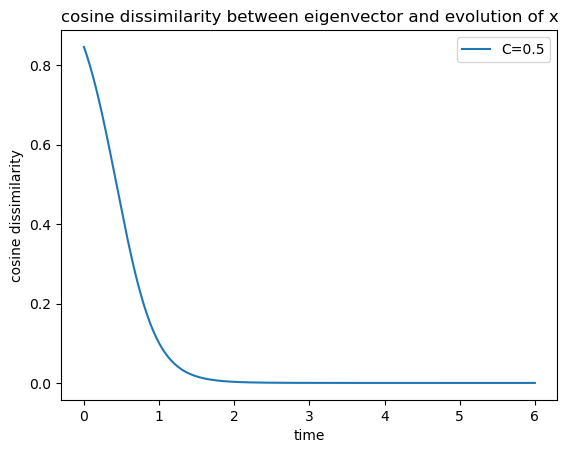

In [57]:
# calculate the eigenvector of the network
eigencentrality_vector = [i for i in nx.eigenvector_centrality(G).values()]

# define a cosine dissimilarity function
def cosine_dissimilarity(x,y):
    return 1-(dot(x,y)/(norm(x)*norm(y)))

# calculate the cosine similarity between the eigenvector and the history
cosine_dissimilarity_history = [cosine_dissimilarity(eigencentrality_vector,history[i]) for i in range(len(time))]
plt.plot(time,cosine_dissimilarity_history, label="C=0.5")
plt.xlabel('time')
plt.ylabel('cosine dissimilarity')
plt.title('cosine dissimilarity between eigenvector and evolution of x')
plt.legend()
plt.show()



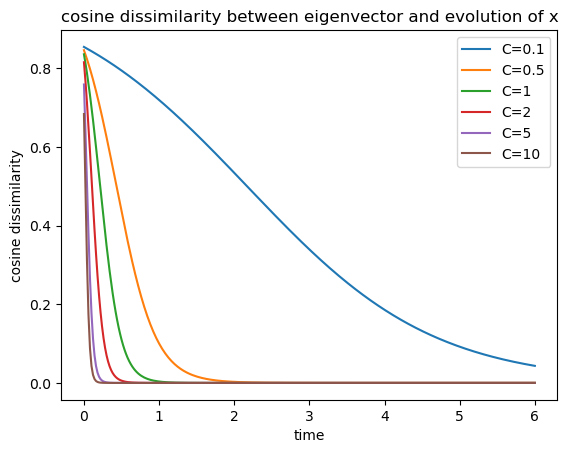

In [64]:
# multiple C
C_list = [0.1, 0.5, 1, 2, 5, 10]
for C in C_list:
    x = zeros(N)
    x[0] = 1
    history_c = network_convergence(C, x, A, dt, time)
    cosine_dissimilarity_history = [cosine_dissimilarity(eigencentrality_vector,history_c[i]) for i in range(len(time))]
    plt.plot(time,cosine_dissimilarity_history, label="C="+str(C))
plt.xlabel('time')
plt.ylabel('cosine dissimilarity')
plt.title('cosine dissimilarity between eigenvector and evolution of x')
plt.legend()

## SI Model

### [4] make SI plot
Simulating SI model...  
Make a plot of the expected fraction of infected people over time using a SI infection model.  
Ajust to see how it effects the evolution


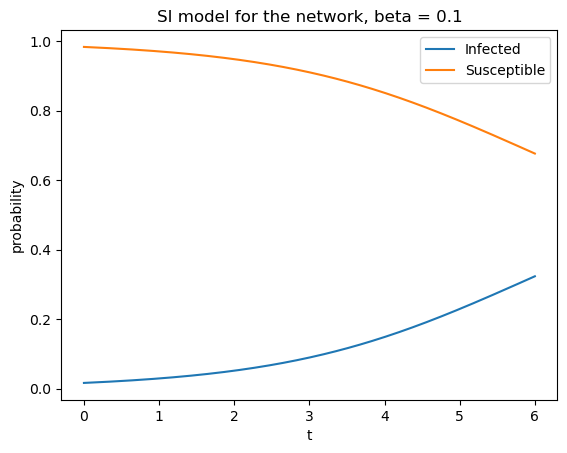

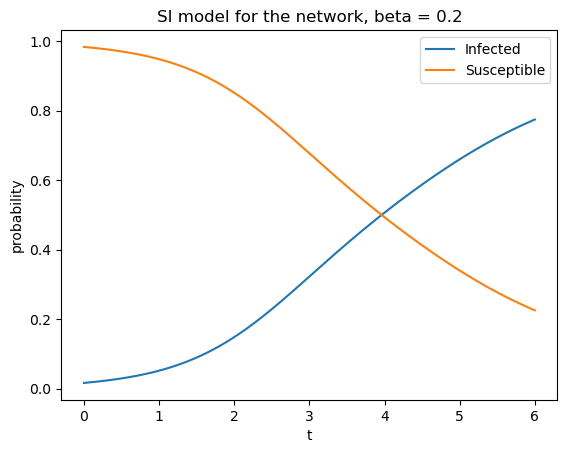

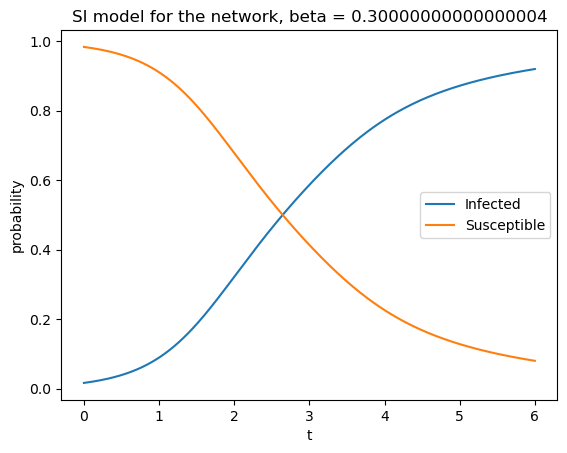

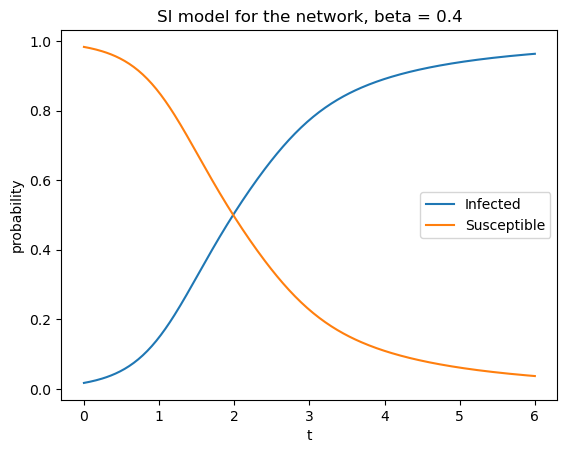

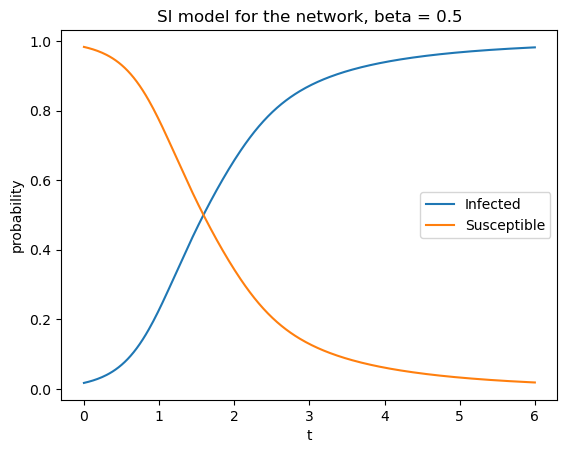

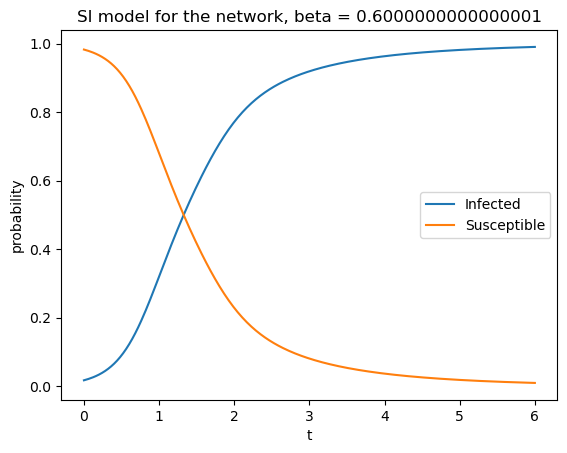

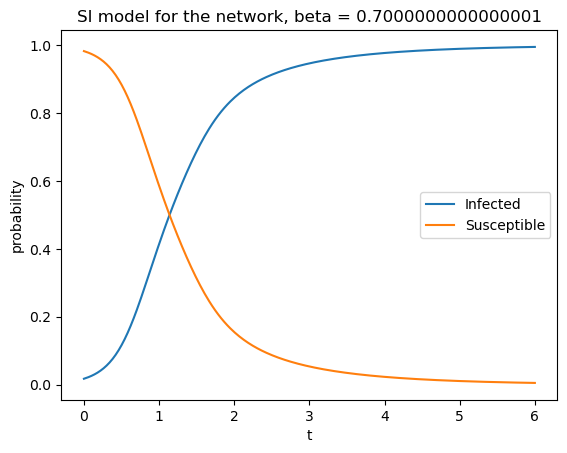

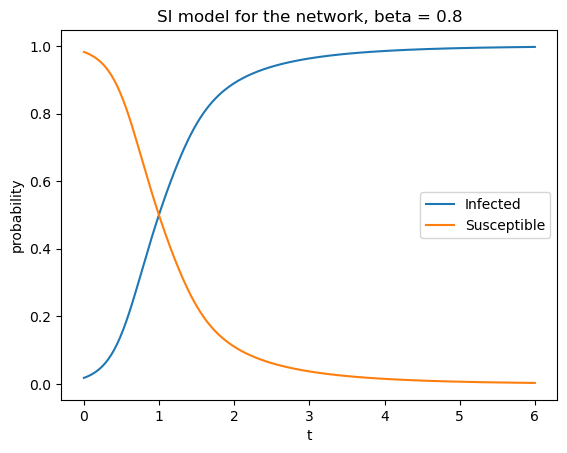

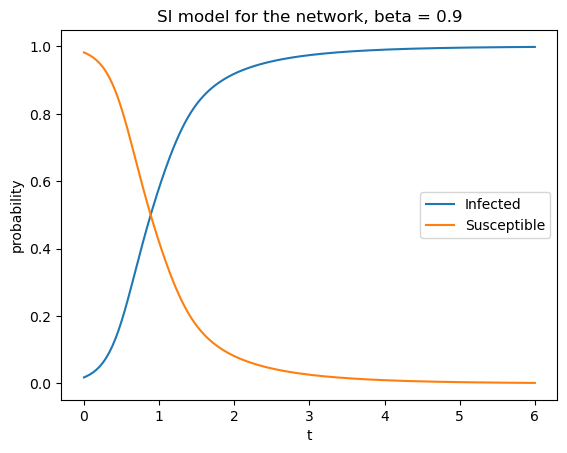

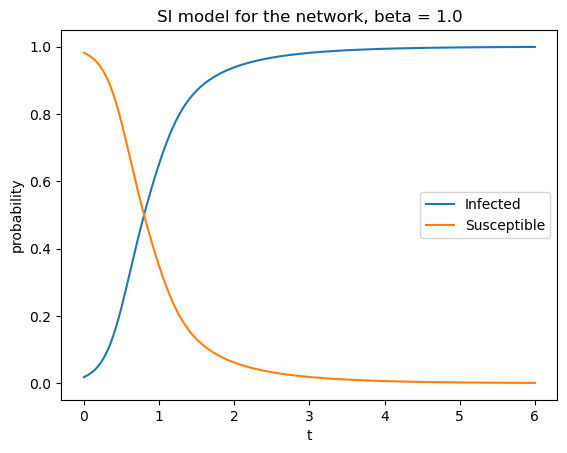

In [75]:
# calculate the SI model for the network
beta = 1
# x is the fraction of infected nodes
# 1-x is the fraction of susceptible nodes


def SI_model(beta, x, s, A, dt, time):
    history_S = []
    history_I = []

    for i,t in enumerate(time):
        x += dt*(beta*dot(A,x)*s) # the dynamics
        s = 1 - x
        history_S.append(mean(s))
        history_I.append(mean(x))
    return history_I, history_S

    

beta_list = arange(0.1, 1.1, 0.1)
for beta in beta_list:
    x = zeros(N)
    x[0] = 1
    s = 1- x
    history_I, history_S = SI_model(beta, x, s, A, dt, time)
    plt.plot(time, history_I, label = 'Infected')
    plt.plot(time, history_S, label = 'Susceptible')
    plt.xlabel('t')
    plt.ylabel('probability')
    plt.title(f'SI model for the network, beta = {beta}')
    plt.legend()
    plt.show()

### [5] Discuss effect of beta

Beta will control how quickly the virus will infect all the population. In other words, `beta` is the contagiousness of the disease, or the infection rate of the disease. Large `beta` will lead to a fast spreading of the disease.

## SIR Model

Simulating SIR model...  
plot 
describe and explain the effect. 

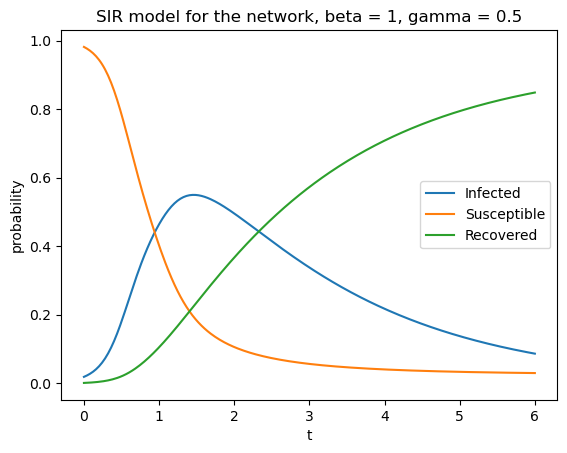

In [85]:
# calculate the SIR model for the network
beta = 1
gamma = 0.5
# x is the fraction of infected nodes
# 1-x is the fraction of susceptible nodes

x = zeros(N)
x[0] = 1
s = 1- x
r = 1-x-s


def SIR_model(beta, gamma, x, s, r, A, dt, time):
    history_S = []
    history_I = []
    history_R = []

    for i,t in enumerate(time):
        x += dt*(beta*dot(A,x)*s - gamma*x) # the dynamics
        s += dt*(-beta*dot(A,x)*s)
        r += dt*(gamma*x)
        history_S.append(mean(s))
        history_I.append(mean(x))
        history_R.append(mean(r))
    return history_I, history_S, history_R

history_I, history_S, history_R = SIR_model(beta, gamma, x, s, r, A, dt, time)

plt.plot(time, history_I, label = 'Infected')
plt.plot(time, history_S, label = 'Susceptible')
plt.plot(time, history_R, label = 'Recovered')
plt.xlabel('t')
plt.ylabel('probability')
plt.title(f'SIR model for the network, beta = {beta}, gamma = {gamma}')
plt.legend()


### Critical point related to gamma


### [6] SIR plot with three different gamma

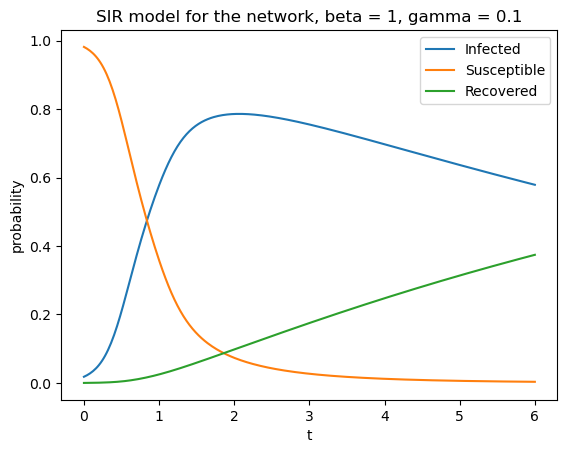

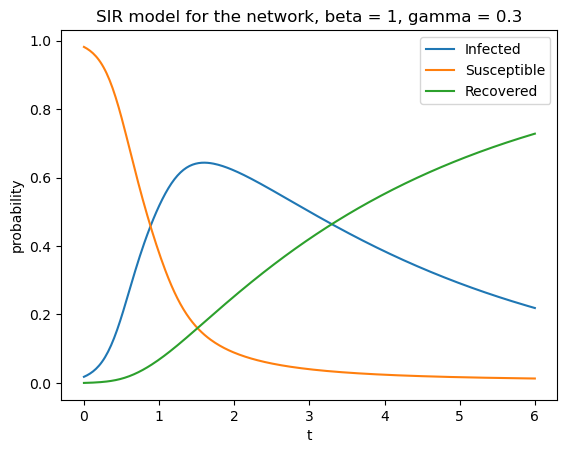

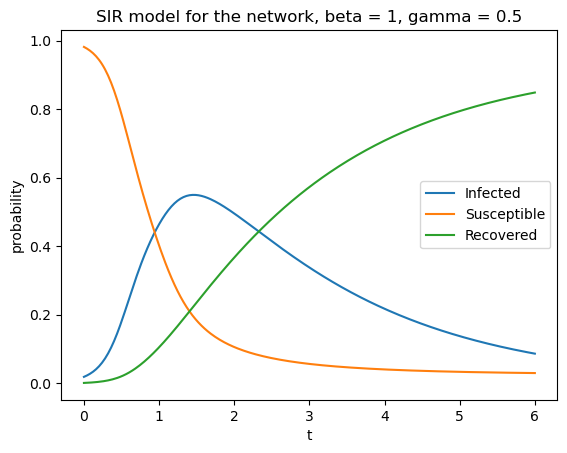

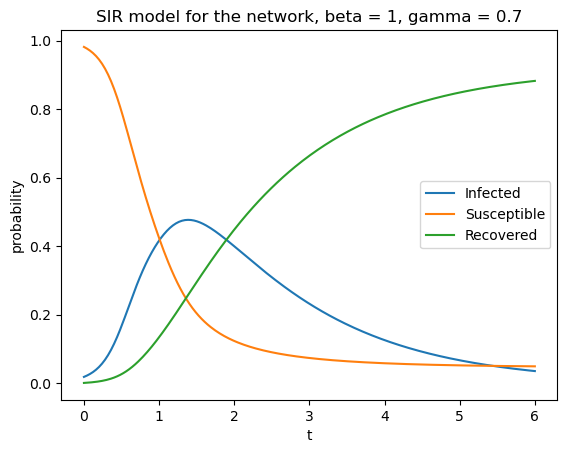

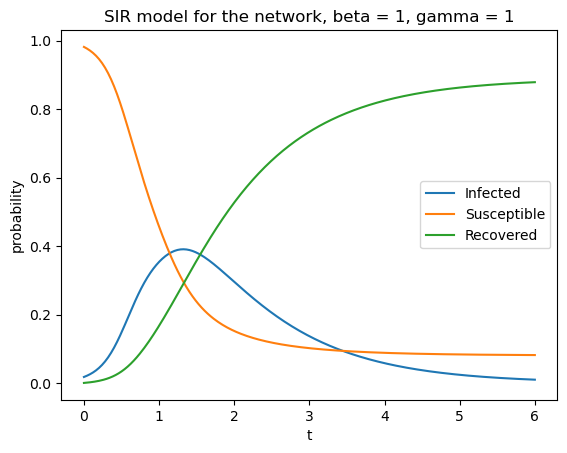

In [170]:
# calculate the SIR model for the network

beta = 1
gamma_list = [ 0.1, 0.3, 0.5, 0.7, 1]
for gamma in gamma_list:
    x = zeros(N)
    x[0] = 1
    s = 1- x
    r = 1-x-s
    history_I, history_S, history_R = SIR_model(beta, gamma, x, s, r, A, dt, time)

    plt.plot(time, history_I, label = 'Infected')
    plt.plot(time, history_S, label = 'Susceptible')
    plt.plot(time, history_R, label = 'Recovered')

    plt.xlabel('t')
    plt.ylabel('probability')
    plt.title(f'SIR model for the network, beta = {beta}, gamma = {gamma}')
    plt.legend()
    plt.show()



### [7] gamma parameters and critical value. 

Gamma is related to the Epidemic threshold. In equation $\beta \lambda_1 - \gamma = 0$. If the $\gamma$ is larger than the $\beta \lambda_1$, it's easier for disease to spread. If it is smaller, it's harder for disease to spread.

In [ ]:
### calculate the eigenvalues of the network
e = linalg.eigvals(A)

# largest eigenvalue
eigen_max = max(e)
# smallest eigenvalue
eigen_min = min(e)

print(eigen_max, eigen_min)

## Independent Cascade

The following function implements an influence cascade model on the graph `G` and initial active node set `x` with the same probability `p` to activate a neighbor node along each edge.

In [111]:
# G: Graph
# p: uniform probability to activate across an edge
# x: initial active seed set (as a list/array)
def influence_cascade(G,p,x):
    G = deepcopy(G)
    x = deepcopy(x)
    activated_nodes = set([])
    for i,xi in enumerate(x):
        if xi > 0:
            activated_nodes.add(G.node_by_index(i))

    while len(activated_nodes) > 0:
        newly_activated = set([])
        for u in activated_nodes:
            x[G.node_index(u)] = 1
            nbrs = G.neighbors(u)
            to_rm = set([])
            for v in nbrs:
                if random.random() <= p:
                    newly_activated.add(v)
                to_rm.add((u,v))
            G.remove_edges_from(to_rm)
        activated_nodes = newly_activated
        #print sum(x)
    return x

Repeating the influence cascade many times...

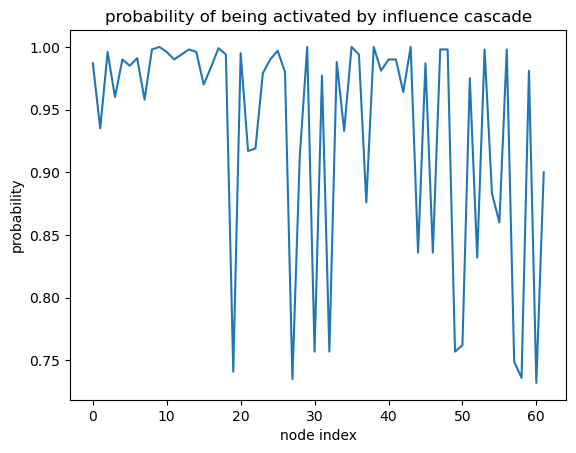

In [159]:
prob_collection = zeros((1000, N))
for i in range(1000):
    # step 0: activate seed set
    x = array([random.choice([0, 1]) for _ in range(N)])
    # step 1: run influence cascade
    x = influence_cascade(G, 0.5, x)
    # step 2: record the probability of being activated
    prob_collection[i] = x

plt.plot(mean(prob_collection, axis=0))
plt.xlabel('node index')
plt.ylabel('probability')
plt.title('probability of being activated by influence cascade')
plt.show()

Using a percolation approach...

In [ ]:
prob_collection = zeros((1000, N))
for i in range(1000):
    # step 0: activate seed set
    x = array([random.choice([0, 1]) for _ in range(N)])
    # step 1: activate seed set based on adjacency matrix A
    matrix = dot(A, x)
    for xi in matrix:
        if xi >= random.random():
            x[xi] = 1
        else:
            x[xi] = 0

        
# define a function to implement percolation on a network
def percolation(G, p):
    G2 = deepcopy(G)
    # step 1: remove edges with probability p
    for u,v in G.edges():
        if random.random() <= p:
            G2.remove_edge(u,v)
    A = array(nx.adjacency_matrix(G2).todense().T)
    the_x = mean(A, axis = 0)
    for xi in the_x:
        if xi >=1:
            xi = 1
    return the_x



def percolation2(G, p, x):
    G = deepcopy(G)
    x = deepcopy(x)
    activated_nodes = set([])
    for i,xi in enumerate(x):
        if xi > 0:
            activated_nodes.add(G.node_by_index(i))

    while len(activated_nodes) > 0:
        newly_activated = set([])
        for u in activated_nodes:
            x[G.node_index(u)] = 1
            nbrs = G.neighbors(u)
            to_rm = set([])
            for v in nbrs:
                if random.random() <= p:
                    newly_activated.add(v)
                to_rm.add((u,v))
            G.remove_edges_from(to_rm)
        activated_nodes = newly_activated
        #print sum(x)

### Final task: late time infection of SIR model predicted by independent cascade model

$<\tau> = 1/\gamma$, so $p = 1 - e^{\beta * 1/\gamma}$

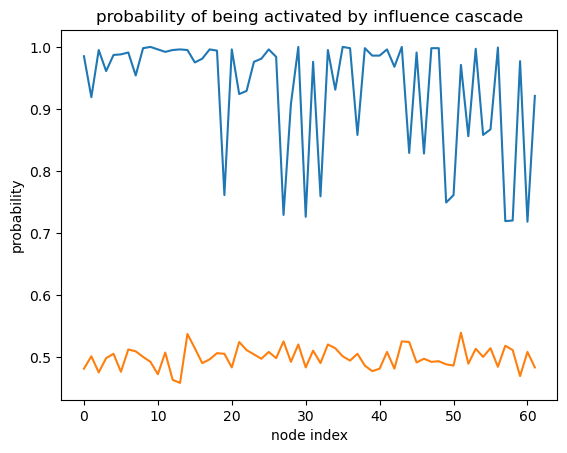

In [169]:
prob_collection = zeros((1000, N))
for i in range(1000):
    # step 0: activate seed set
    x = array([random.choice([0, 1]) for _ in range(N)])
    # step 1: run influence cascade
    x = influence_cascade(G, 0.5, x)
    # step 2: record the probability of being activated
    prob_collection[i] = x


prob_collection_SIR = zeros((1000, N))
prob = 1- exp(beta*(1/eigen_max))

for i in range(1000):
    # step 0: activate seed set
    x = array([random.choice([0, 1]) for _ in range(N)])
    # step 1: run influence cascade
    x = influence_cascade(G, prob, x)
    # step 2: record the probability of being activated
    prob_collection_SIR[i] = x



plt.plot(mean(prob_collection, axis=0), label = 'influence cascade')
plt.plot(mean(prob_collection_SIR, axis=0), label = 'SIR model')
plt.xlabel('node index')
plt.ylabel('probability')
plt.title('probability of being activated by influence cascade')
plt.show()

### [8] three models together: independent cascade, percolation, SIR